Overfitting Demo
===

In [17]:
%config InlineBackend.figure_format = 'retina'

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

def get_simulated_data(n=1000):    
    X1 = np.random.normal(0, 1, n)
    X2 = np.random.beta(2, 5, n)
    X3 = np.random.uniform(-1, 1, n)
    noise = np.random.normal(0, 0.1, n)
    
    y_prob = 1 / (1 + np.exp(-3 * (X1**2 - X2 + 0.5 * X3)))  # Non-linear function
    y = (y_prob + noise > 0.5).astype(int)
    
    X = np.column_stack([X1, X2, X3])
    return X, y

def create_benchmark(X, y, test_size=0.2, seed=None):
    return train_test_split(X, y, test_size=test_size, random_state=seed)

def do_modeling(X_train, y_train, X_test, y_test, verbose: bool = True):
    param_grid = {
        'max_iter': [100, 200], 
        'max_depth': [3, 5, 7], 
        'learning_rate': [0.1, 0.5], 
        'max_depth': [None, 2],
    }
    best_acc = 0
    best_model = None
    # TODO to improve this simulation, we should randomize the parameters in the parameter grid
    # and then keep track of our performance each time we find a new best model
    for params in ParameterGrid(param_grid):
        model = HistGradientBoostingClassifier(**params)
        model.fit(X_train, y_train)
    
        y_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        if test_acc > best_acc:
            best_acc = test_acc
            best_model = model
    if verbose:
        print(f"Best test accuracy: {best_acc:.4f}")
    
    return best_model, best_acc

def demonstrate_overfitting(seed: int, verbose: bool = False):
    np.random.seed(seed)
    X, y = get_simulated_data(n=500)
    X_train, X_test, y_train, y_test = create_benchmark(X, y, seed=42)
    model, best_test_acc = do_modeling(X_train, y_train, X_test, y_test, verbose=verbose)
    
    # Generate a truly held-out dataset
    X_holdout, y_holdout = get_simulated_data(n=10000)
    y_pred_holdout = model.predict(X_holdout)
    holdout_acc = accuracy_score(y_holdout, y_pred_holdout)
    if verbose:
        print(f"Holdout accuracy: {holdout_acc:.4f}")
    return best_test_acc, holdout_acc

In [3]:
X, y = get_simulated_data(n=500)
X_train, X_test, y_train, y_test = create_benchmark(X, y, seed=42)
f"{y.sum() / len(y):.1%} of rows have y == 1, the rest 0"

'67.4% of rows have y == 1, the rest 0'

In [5]:
model, _ = do_modeling(X_train, y_train, X_test, y_test)

Best test accuracy: 0.9300


In [6]:
# Generate a truly held-out dataset
X_holdout, y_holdout = get_simulated_data(n=500)
y_pred_holdout = model.predict(X_holdout)
holdout_acc = accuracy_score(y_holdout, y_pred_holdout)
print(f"Holdout accuracy: {holdout_acc:.4f}")

Holdout accuracy: 0.9100


In [38]:
n = 600
seeds = np.random.randint(1, 100000, size=n)
for seed in tqdm(seeds, desc="Simulating overfitting"):
    best_test_acc, holdout_acc = demonstrate_overfitting(seed)
    results.append((best_test_acc, holdout_acc))

Simulating overfitting: 100%|█████████████████████████████████████████████████████████████████| 200/200 [07:55<00:00,  2.38s/it]


In [47]:
df = pd.DataFrame(results, columns=["Benchmark Acc", "True Acc"])
df["Accuracy Difference"] = df["Benchmark Acc"] - df["True Acc"]

In [48]:
acc_diff = df["Accuracy Difference"]
acc_diff.describe()

count    600.000000
mean       0.014656
std        0.026905
min       -0.085400
25%       -0.001325
50%        0.016650
75%        0.032775
max        0.082500
Name: Accuracy Difference, dtype: float64

In [52]:
acc_diff.quantile(0.05), acc_diff.quantile(0.95)

(np.float64(-0.03480000000000005), np.float64(0.05380499999999996))

In [55]:
(acc_diff > 0).sum() / len(acc_diff)

np.float64(0.7283333333333334)

In [95]:
(acc_diff > 0.02).sum() / len(acc_diff)

np.float64(0.43333333333333335)

In [92]:
import scipy.stats
mean_diff = np.mean(acc_diff)
sem_diff = scipy.stats.sem(acc_diff)
ci = scipy.stats.t.interval(0.95, df=len(acc_diff)-1, loc=mean_diff, scale=sem_diff)
print(f"Mean difference: {mean_diff:.1%}")
print(f"95% Confidence Interval: ({ci[0]:.1%}, {ci[1]:.1%})")

Mean difference: 1.5%
95% Confidence Interval: (1.2%, 1.7%)


In [49]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.family'] = "serif"

In [ ]:
results = []

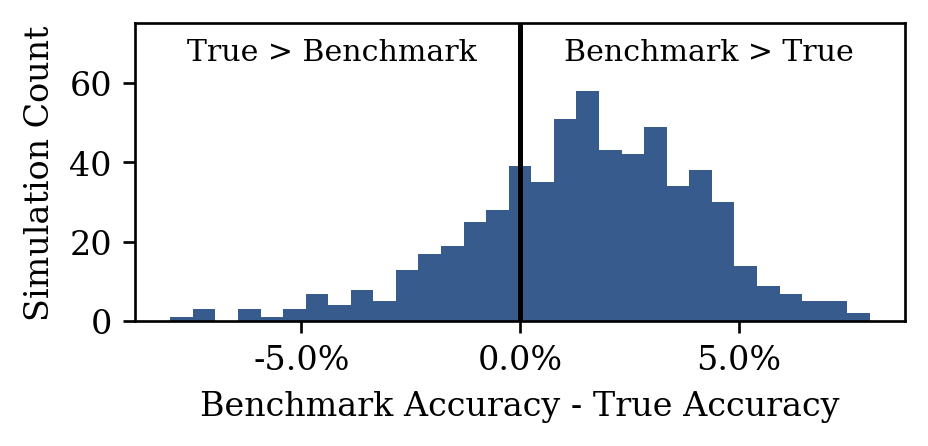

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2))

ax.hist(acc_diff, bins=np.linspace(-0.08, 0.08, num=32), color=matplotlib.cm.viridis(0.28149))

ax.set_ylabel("Simulation Count")
ax.set_xlabel("Benchmark Accuracy - True Accuracy")
ax.axvline(0, color="black")
ax.set_ylim((0, 75))
ax.text(-0.01, ax.get_ylim()[1] * 0.95, "True > Benchmark", ha="right", va="top", fontsize=9)
ax.text(0.01, ax.get_ylim()[1] * 0.95, "Benchmark > True", ha="left", va="top", fontsize=9)


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, pos: f"{y:.1%}"))

fig.tight_layout(pad=1.16)
fig.savefig("overfitting_sim_hist_n600.svg", transparent=False)
plt.show()